## Basics

In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [37]:
# imports 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier
import xgboost as xgb

In [38]:
df = pd.read_csv('train.csv')

In [39]:
target = df['Response']
id = df['id']
df.drop(columns=['id', 'Region_Code', 'Response'], inplace=True)

In [40]:
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('category')

## EDA

In [6]:
df.columns

Index(['Gender', 'Age', 'Driving_License', 'Previously_Insured', 'Vehicle_Age',
       'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')

In [7]:
df.head()

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,21,1,0,1-2 Year,Yes,65101.0,124.0,187
1,Male,43,1,0,> 2 Years,Yes,58911.0,26.0,288
2,Female,25,1,1,< 1 Year,No,38043.0,152.0,254
3,Female,35,1,0,1-2 Year,Yes,2630.0,156.0,76
4,Female,36,1,1,1-2 Year,No,31951.0,152.0,294


In [8]:
df.describe()

,Age,Driving_License,Previously_Insured,Annual_Premium,Vintage
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,3.838356e+01,9.980220e-01,4.629966e-01,3.046137e+04,1.638977e+02
std,1.499346e+01,4.443120e-02,4.986289e-01,1.645475e+04,7.997953e+01
min,2.000000e+01,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+01
25%,2.400000e+01,1.000000e+00,0.000000e+00,2.527700e+04,9.900000e+01
50%,3.600000e+01,1.000000e+00,0.000000e+00,3.182400e+04,1.660000e+02
75%,4.900000e+01,1.000000e+00,1.000000e+00,3.945100e+04,2.320000e+02
max,8.500000e+01,1.000000e+00,1.000000e+00,5.401650e+05,2.990000e+02


{'whiskers': [<matplotlib.lines.Line2D at 0x1b1ba8d4280>,
 'caps': [<matplotlib.lines.Line2D at 0x1b1ba8d47c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b1ba8bbfa0>],
 'medians': [<matplotlib.lines.Line2D at 0x1b1ba8d4d00>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b1ba8d4fa0>],
 'means': []}

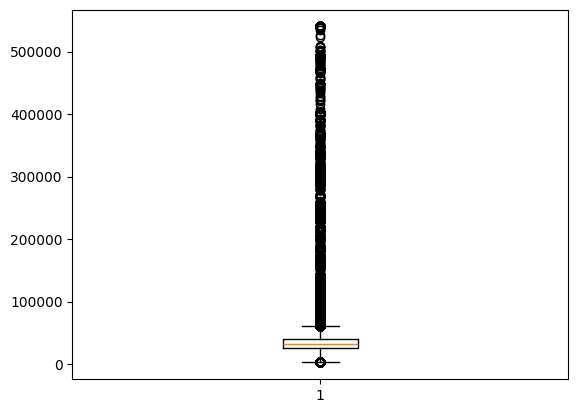

In [9]:
plt.boxplot(df['Annual_Premium'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1b1ba90faf0>,
 'caps': [<matplotlib.lines.Line2D at 0x1b1ba91e070>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b1ba90f850>],
 'medians': [<matplotlib.lines.Line2D at 0x1b1ba91e5b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b1ba91e850>],
 'means': []}

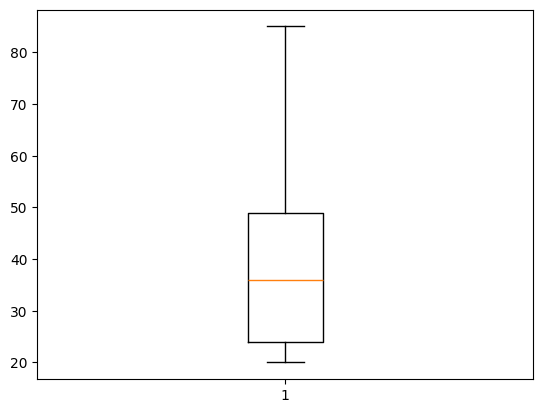

In [10]:
plt.boxplot(df['Age'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1b1ba98b310>,
 'caps': [<matplotlib.lines.Line2D at 0x1b1ba98b850>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b1ba98b070>],
 'medians': [<matplotlib.lines.Line2D at 0x1b1ba98bd90>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b1ba999070>],
 'means': []}

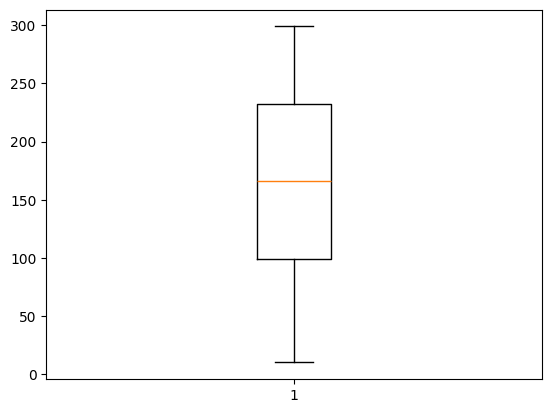

In [11]:
plt.boxplot(df['Vintage'])

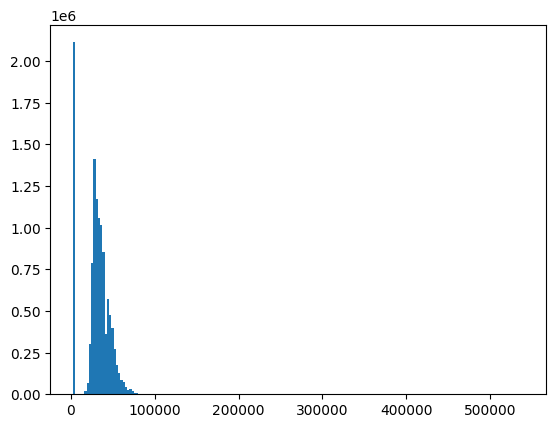

In [12]:
plt.hist(df['Annual_Premium'], bins=200)
plt.show()

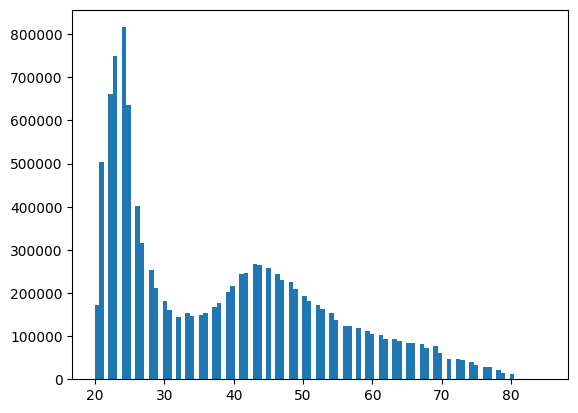

In [13]:
plt.hist(df['Age'], bins=100)
plt.show()

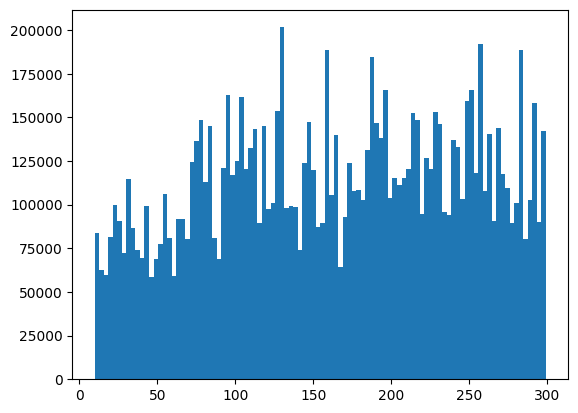

In [14]:
plt.hist(df['Vintage'], bins=100)
plt.show()

## Feature Engineering 

In [41]:
def gender_to_num(gender):
    if gender == 'Male':
        return 1
    return 0 

In [42]:
def age_to_number(age):
    if age == '< 1 Year':
        return 0
    elif age == '1-2 Year':
        return 1
    else:
        return 2

In [43]:
def damage_to_number(damage):
    if damage == 'Yes':
        return 1
    return 0

In [44]:
df['NewDriver'] = (df['Driving_License'] == 1) & (df['Age'] < 21)

In [45]:
df['HighValue'] = (df['Vintage'] > 200) & (df['Annual_Premium'] > 30000)

In [46]:
def bool_to_int(bool_val):
    if bool_val:
        return 1
    return 0

In [47]:
df['NewDriver'] = df['NewDriver'].apply(bool_to_int)
df['HighValue'] = df['HighValue'].apply(bool_to_int)
df['Gender'] = df['Gender'].apply(gender_to_num)
df['Vehicle_Age'] = df['Vehicle_Age'].apply(age_to_number)
df['Vehicle_Damage'] = df['Vehicle_Damage'].apply(damage_to_number)

In [48]:
df.drop(columns=['Driving_License', 'Vintage'], inplace=True)

## Scaling

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.3, random_state=55)

In [50]:
xtrain_policy = X_train['Policy_Sales_Channel']  
xtest_policy = X_test['Policy_Sales_Channel']
X_train = X_train.drop(columns=['Policy_Sales_Channel'])
X_test = X_test.drop(columns=['Policy_Sales_Channel'])

In [51]:
scaler = StandardScaler()
scaler.fit(X_train)
numerical_columns = df.columns.drop('Policy_Sales_Channel')
X_train = pd.DataFrame(scaler.transform(X_train), columns=numerical_columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=numerical_columns)

In [52]:
X_train = pd.concat([X_train, xtrain_policy.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test, xtest_policy.reset_index(drop=True)], axis=1)

## Logistic Regression

In [53]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [54]:
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_accuracy

0.876782154694852

In [55]:
lr_prob = lr.predict_proba(X_test)
lr_prob = lr_prob[:, 1]

## Decision Tree

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_prob = dt.predict_proba(X_test)
dt_prob = dt_prob[:, 1]
dt_accuracy

## Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators = 10, random_state=55)
rf.fit(X_train, y_train)

In [ ]:
rf_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

In [ ]:
rf_accuracy

## XGBoost

In [ ]:
xgb_params = {
    'objective': 'binary:logistic',
    'max_depth': 10,
    'eta': 0.5,
    'eval_metric': 'logloss'
}

In [ ]:
X_train.head()

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [ ]:
xgb_model = xgb.train(xgb_params, dtrain, 100, evals=[(dtest, 'eval'), (dtrain, 'train')])

In [ ]:
xgb_prob = xgb_model.predict(dtest)
xgb_pred = (xgb_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, xgb_pred)
accuracy

## CatBoost

In [ ]:
cb = CatBoostClassifier(
    iterations=500,
    depth=10,
    learning_rate=0.3,
    loss_function='Logloss',
    cat_features=['Policy_Sales_Channel']
)

In [ ]:
X_train['Policy_Sales_Channel'] = X_train['Policy_Sales_Channel'].astype('int')
X_test['Policy_Sales_Channel'] = X_test['Policy_Sales_Channel'].astype('int')

In [ ]:
cb.fit(X_train, y_train, cat_features=['Policy_Sales_Channel'])

In [ ]:
cb_pred = cb.predict(X_test)

In [ ]:
cb_accuracy = accuracy_score(y_test, cb_pred)
cb_accuracy

## Ensemble

In [ ]:
#lr_prob = lr.predict_proba(X_train)
#dt_prob = dt.predict_proba(X_train)
#rf_prob = rf.predict_proba(X_train)
xgb_prob = xgb_model.predict(xgb.DMatrix(X_train))
cb_prob = cb.predict_proba(X_train)

In [ ]:
meta_df = pd.DataFrame()
#lr_prob = lr_prob[:, 1]
#dt_prob = dt_prob[:, 1]
#rf_prob = rf_prob[:, 1]
cb_prob = cb_prob[:, 1]

In [ ]:
#meta_df['LR'] = lr_prob
#meta_df['DT'] = dt_prob
#meta_df['RF'] = rf_prob
meta_df['xgb'] = xgb_prob
meta_df['cb'] = cb_prob

In [ ]:
meta = LogisticRegression()

In [ ]:
meta.fit(meta_df, y_train)

In [ ]:
#lr_prob = lr.predict_proba(X_test)
#dt_prob = dt.predict_proba(X_test)
#rf_prob = rf.predict_proba(X_test)
xgb_prob = xgb_model.predict(xgb.DMatrix(X_test))
cb_prob = cb.predict_proba(X_test)

In [ ]:
meta_df = pd.DataFrame()
#lr_prob = lr_prob[:, 1]
#dt_prob = dt_prob[:, 1]
#rf_prob = rf_prob[:, 1]
cb_prob = cb_prob[:, 1]

In [ ]:
#meta_df['LR'] = lr_prob
#meta_df['DT'] = dt_prob
#meta_df['RF'] = rf_prob
meta_df['xgb'] = xgb_prob
meta_df['cb'] = cb_prob

In [ ]:
meta_pred = meta.predict(meta_df)
meta_accuracy = accuracy_score(y_test, meta_pred)
meta_accuracy

## Submission

In [ ]:
test_df = pd.read_csv('test.csv')
test_id = test_df['id']
test_df.drop(columns=['id', 'Region_Code'], inplace=True)
test_df['Gender'] = test_df['Gender'].apply(gender_to_num)
test_df['Vehicle_Age'] = test_df['Vehicle_Age'].apply(age_to_number)
test_df['Vehicle_Damage'] = test_df['Vehicle_Damage'].apply(damage_to_number)

In [ ]:
test_policy = test_df['Policy_Sales_Channel']
test_df.drop(columns=['Policy_Sales_Channel'], inplace=True)

In [ ]:
numerical_columns = test_df.columns
test_df = pd.DataFrame(scaler.transform(test_df), columns=numerical_columns)
test_df = pd.concat([test_df, test_policy.reset_index(drop=True)], axis=1)

In [ ]:
test_df['Policy_Sales_Channel'] = test_df['Policy_Sales_Channel'].astype(int)

In [ ]:
#lr_test = lr.predict_proba(test_df)
#dt_test = dt.predict_proba(test_df)
#rf_test = rf.predict_proba(test_df)
xgb_test = xgb_model.predict(xgb.DMatrix(test_df))
cb_test = cb.predict_proba(test_df)

In [ ]:
#lr_test = lr_test[:, 1]
#dt_test = dt_test[:, 1]
#rf_test = rf_test[:, 1]
cb_test = cb_test[:, 1]

In [ ]:
test_meta = pd.DataFrame()
test_meta['xgb'] = xgb_test
test_meta['cb'] = cb_test

In [ ]:
response = meta.predict_proba(test_meta)[:, 1]

In [ ]:
result = pd.DataFrame()
result['id'] = test_id
result['Response'] = response

In [ ]:
result.to_csv('submission.csv', index=False)

## Feature Importances 

<BarContainer object of 13 artists>

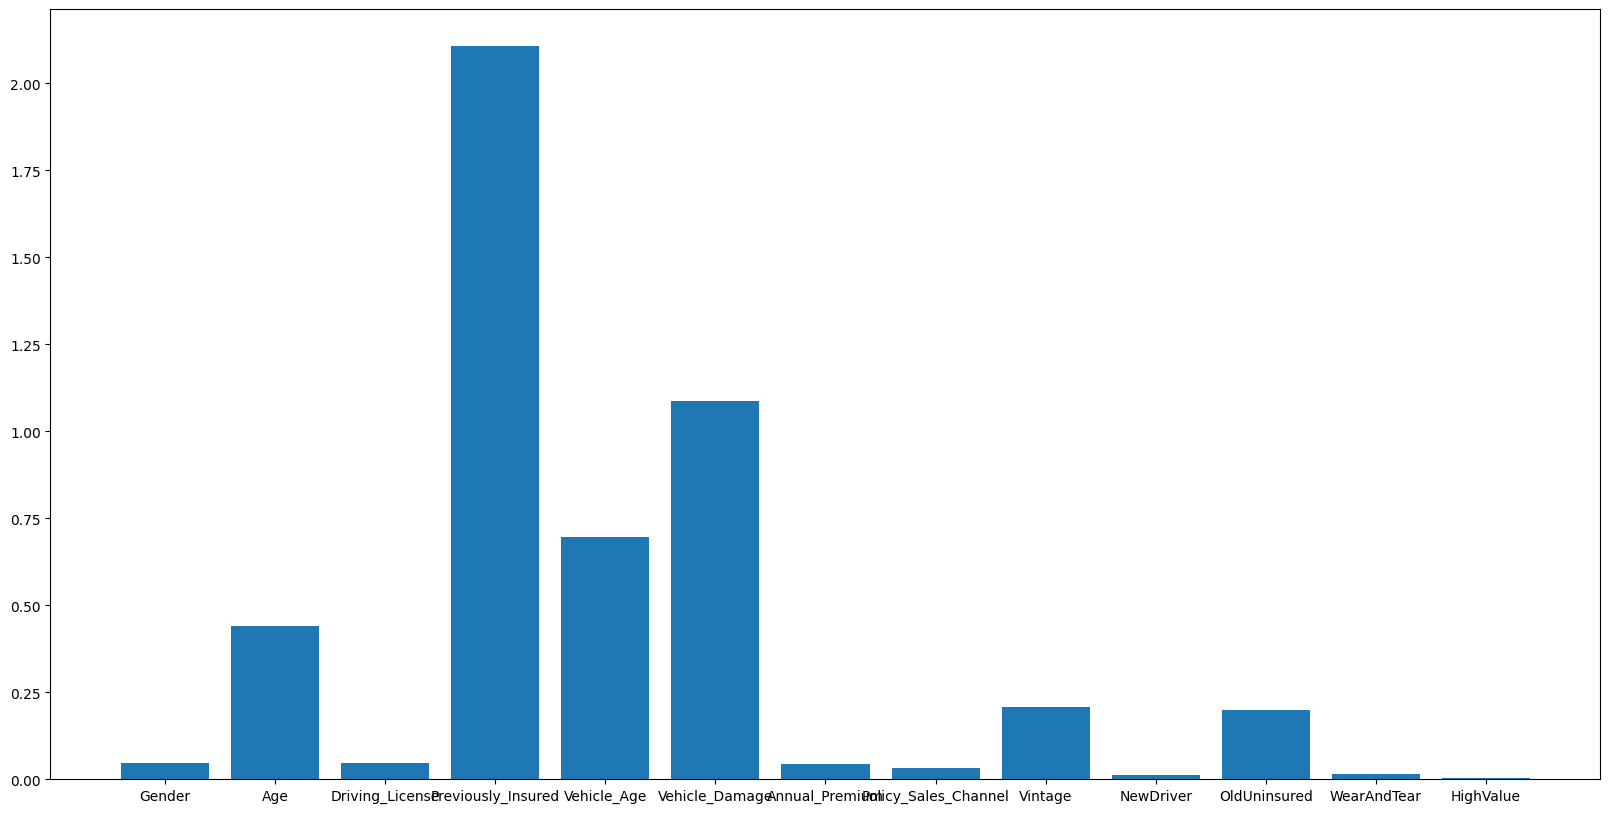

In [105]:
lr_coef = lr.coef_[0]
plt.figure(figsize=(20, 10))
plt.bar(df.columns, abs(lr_coef))

<BarContainer object of 13 artists>

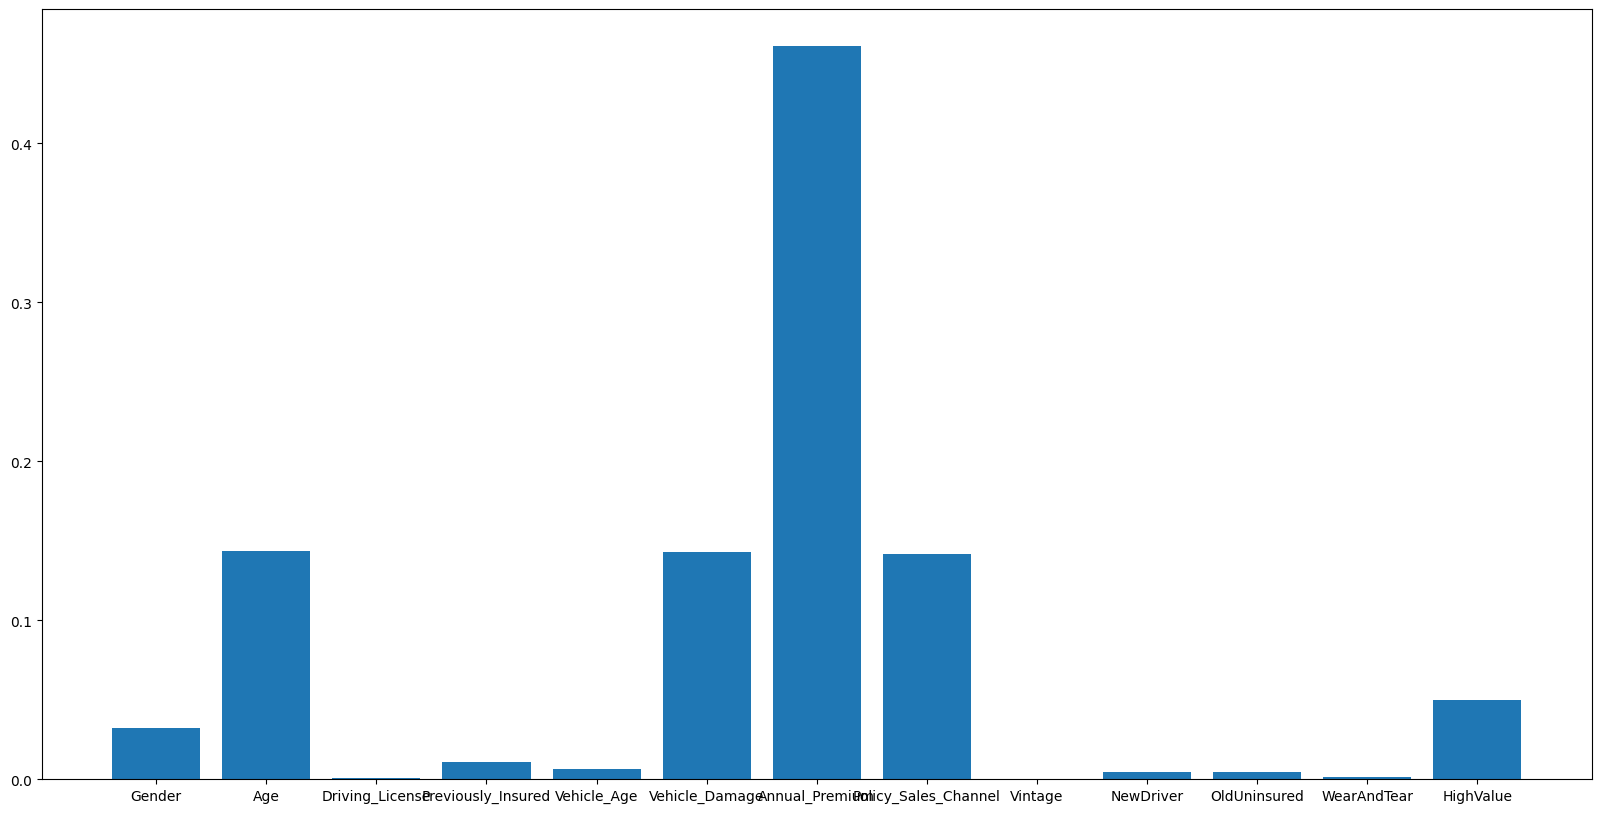

In [106]:
dt_fi = dt.feature_importances_
plt.figure(figsize=(20, 10))
plt.bar(df.columns, abs(dt_fi))

<BarContainer object of 13 artists>

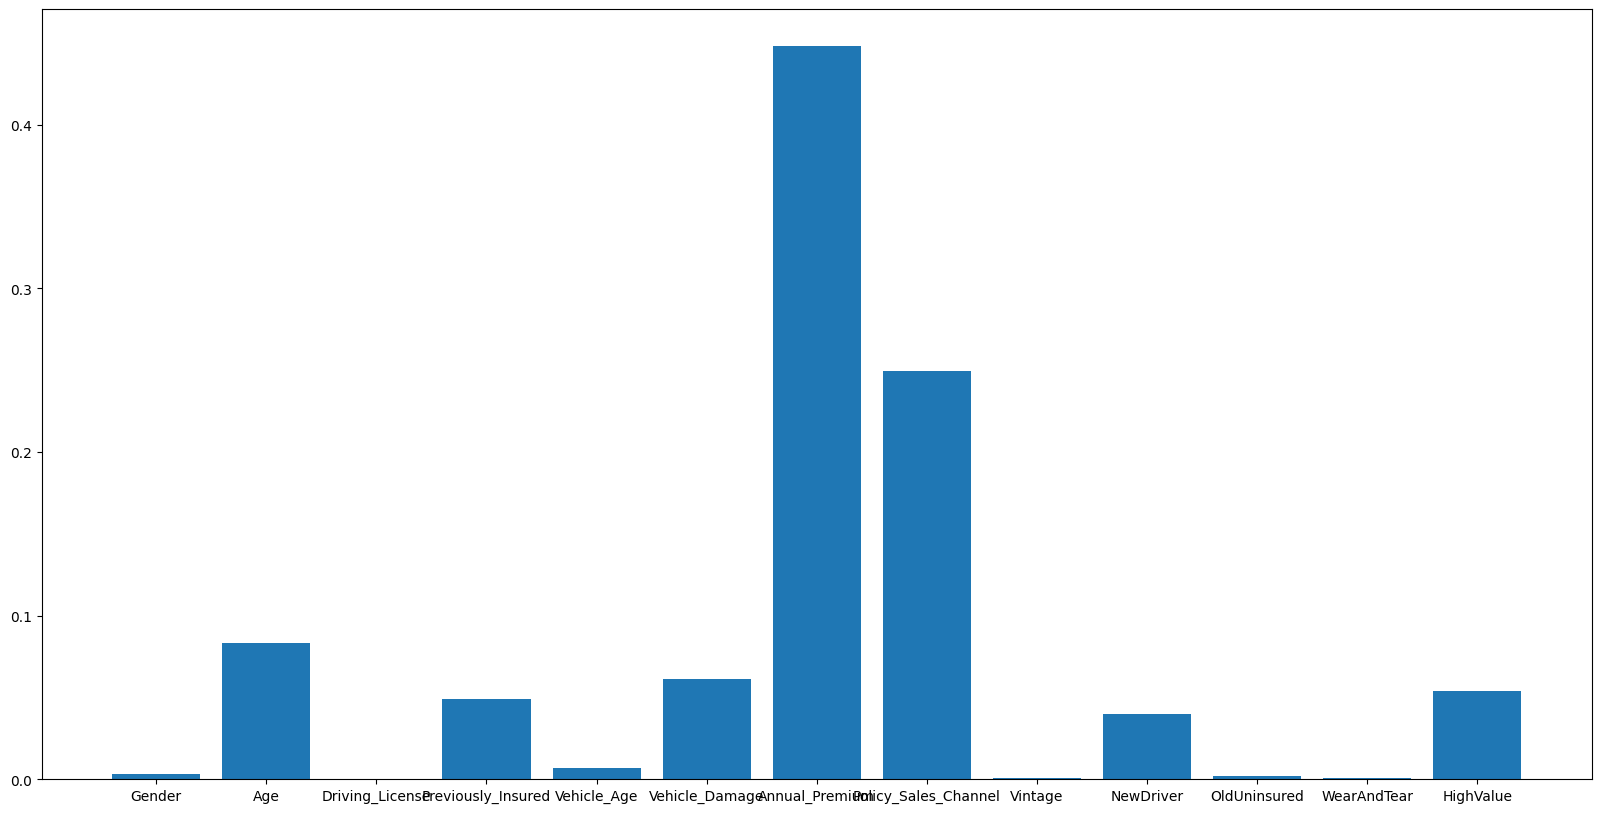

In [107]:
rf_fi = rf.feature_importances_
plt.figure(figsize=(20, 10))
plt.bar(df.columns, abs(rf_fi))

<BarContainer object of 12 artists>

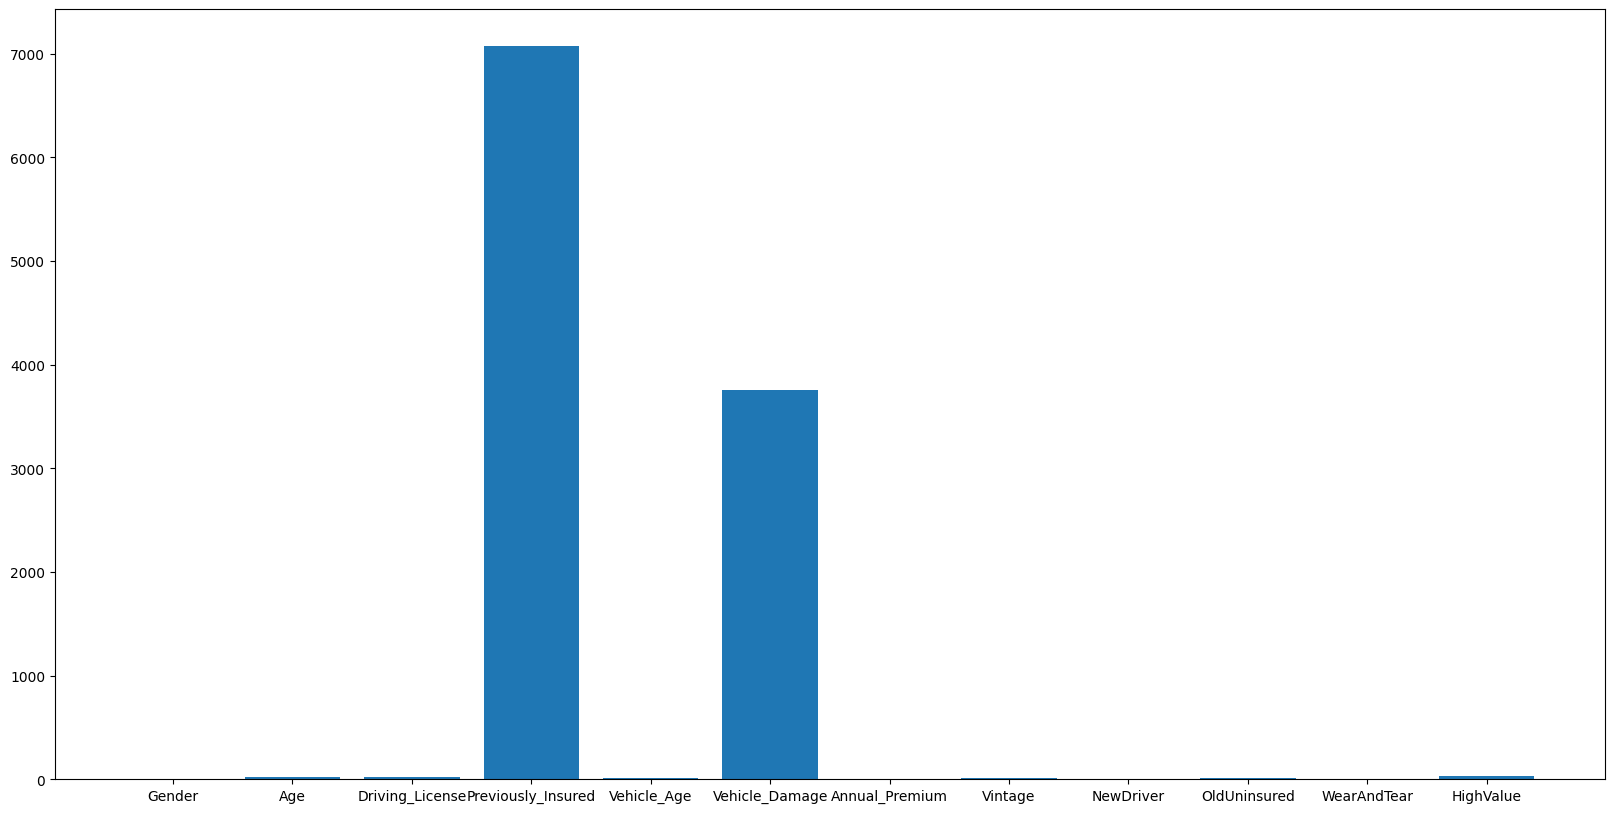

In [115]:
xgb_fi = xgb_model.get_score(importance_type='gain')
xgb_fi = np.array(list(xgb_fi.values()))
plt.figure(figsize=(20, 10))
plt.bar(df.columns.drop('Policy_Sales_Channel'), xgb_fi)

<BarContainer object of 13 artists>

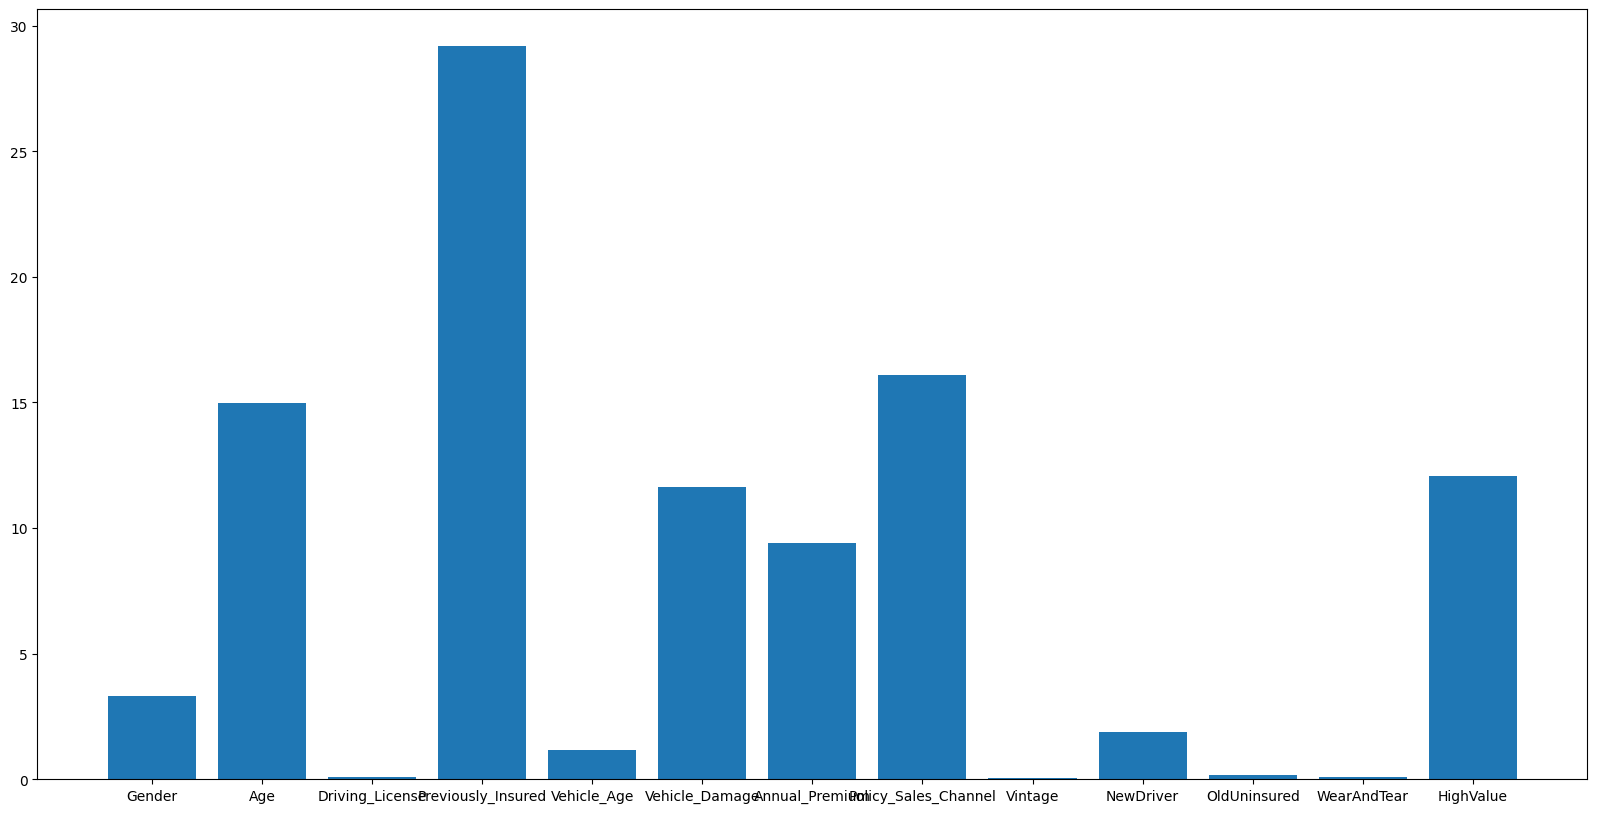

In [110]:
cb_fi = cb.get_feature_importance()
plt.figure(figsize=(20, 10))
plt.bar(df.columns, abs(cb_fi))